In [ ]:
import zipfile
import shutil 
import os
from time import time
from datetime import datetime as dt

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
import cv2

In [ ]:
def display_img(img_list, nrow = 1, ncol = 0, size = (10,10), text = [], cmap = False):

  if not ncol:
    ncol = len(img_list)
  if not cmap:
    cmap = [None for i in range(len(img_list))]
  
  fig = plt.figure(figsize=(size[0], size[1]))
  k = 0
  for i in range(nrow):
    for j in range(ncol):
      current_plot = fig.add_subplot(nrow, ncol, k+1)
      if k < len(text):
        current_plot.title.set_text(text[k])
      plt.imshow(img_list[k], cmap[k])
      k += 1

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ifigotin/imagenetmini-1000

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 3.92G/3.92G [00:55<00:00, 70.4MB/s]
100% 3.92G/3.92G [00:55<00:00, 76.3MB/s]


In [ ]:
zipped = zipfile.ZipFile('/content/imagenetmini-1000.zip')
zipped.extractall()
zipped.close()

In [ ]:
shutil.copyfile(
    '/content/imagenetmini-1000.zip',
    '/content/drive/MyDrive/DSIM/image_classification/imagenetmini-1000.zip'
    )

'/content/drive/MyDrive/DSIM/image_classification/imagenetmini-1000.zip'

In [ ]:
all_data = [
            '/'.join(['/content/imagenet-mini', subset, folder, img])
            for subset in os.listdir('/content/imagenet-mini')
            for folder in os.listdir('/'.join(['/content/imagenet-mini', subset]))
            for img in os.listdir('/'.join(['/content/imagenet-mini', subset, folder]))
]

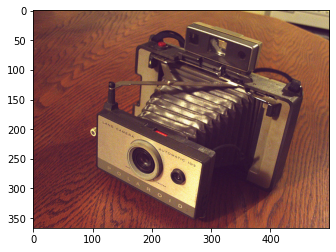

In [ ]:
image = cv2.imread(all_data[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [ ]:
# funzione per sfocare le immagini
def blur_gaussian(image, size):
  return cv2.GaussianBlur(image, (size, size), 10), None

# filtro per immagine mossa orizzontalmente
def horiz_motion(image, ksize):
  kernel_motion_oriz = np.zeros((ksize, ksize))
  kernel_motion_oriz[int(ksize/2), :] = 1/ksize
  output = cv2.filter2D(image, -1, kernel_motion_oriz)
  return output, kernel_motion_oriz

# filtro per immagine mossa verticalmente
def vert_motion(image, ksize):
  kernel_motion_vert = np.zeros((ksize, ksize))
  kernel_motion_vert[:, int(ksize/2)] = 1/ksize
  output = cv2.filter2D(image, -1, kernel_motion_vert)
  return output, kernel_motion_vert

Filtri 2d

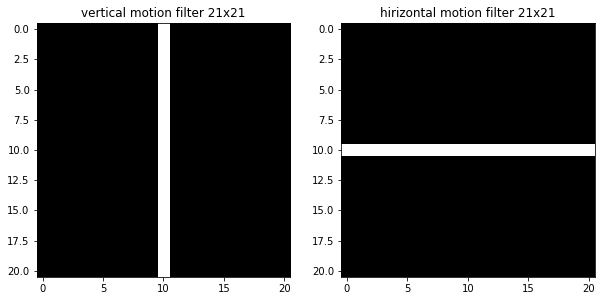

In [ ]:
ksize = 21
display_img(
    [
     vert_motion(image, ksize)[1]*255,
     horiz_motion(image, ksize)[1]*255
    ],
    text = ['vertical motion filter {}x{}'.format(ksize,ksize),
            'hirizontal motion filter {}x{}'.format(ksize,ksize)],
    cmap = ['gray', 'gray']

)

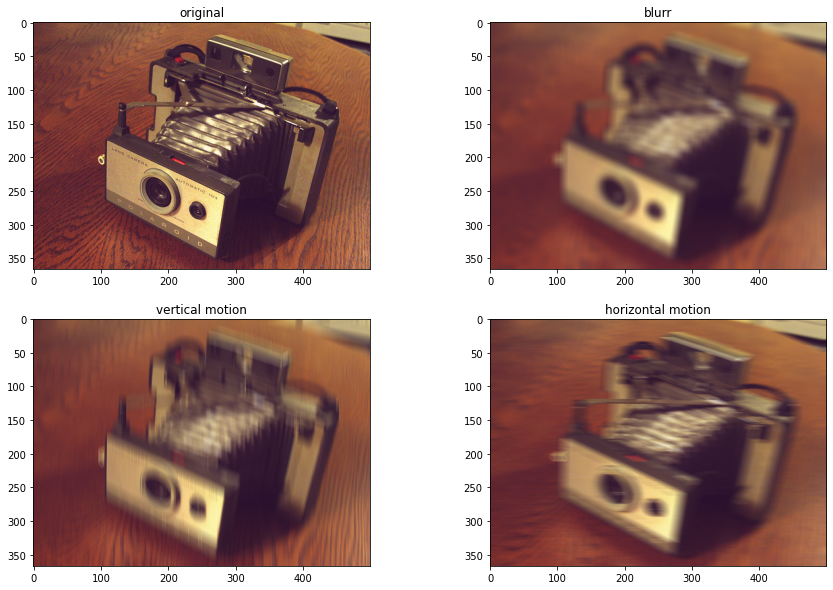

In [ ]:
display_img(
    [
     image,
     blur_gaussian(image, 15)[0],
     vert_motion(image, 21)[0],
     horiz_motion(image, 21)[0]
     ],
    2,2, (15,10),
    text = ['original', 'blurr', 'vertical motion', 'horizontal motion']
)

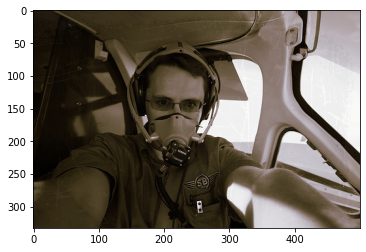

In [ ]:
image2 = cv2.imread(all_data[99])
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
plt.imshow(image2)

Diverse trasformazioni che verranno applicate (facendo variare la dimensione del filtro)

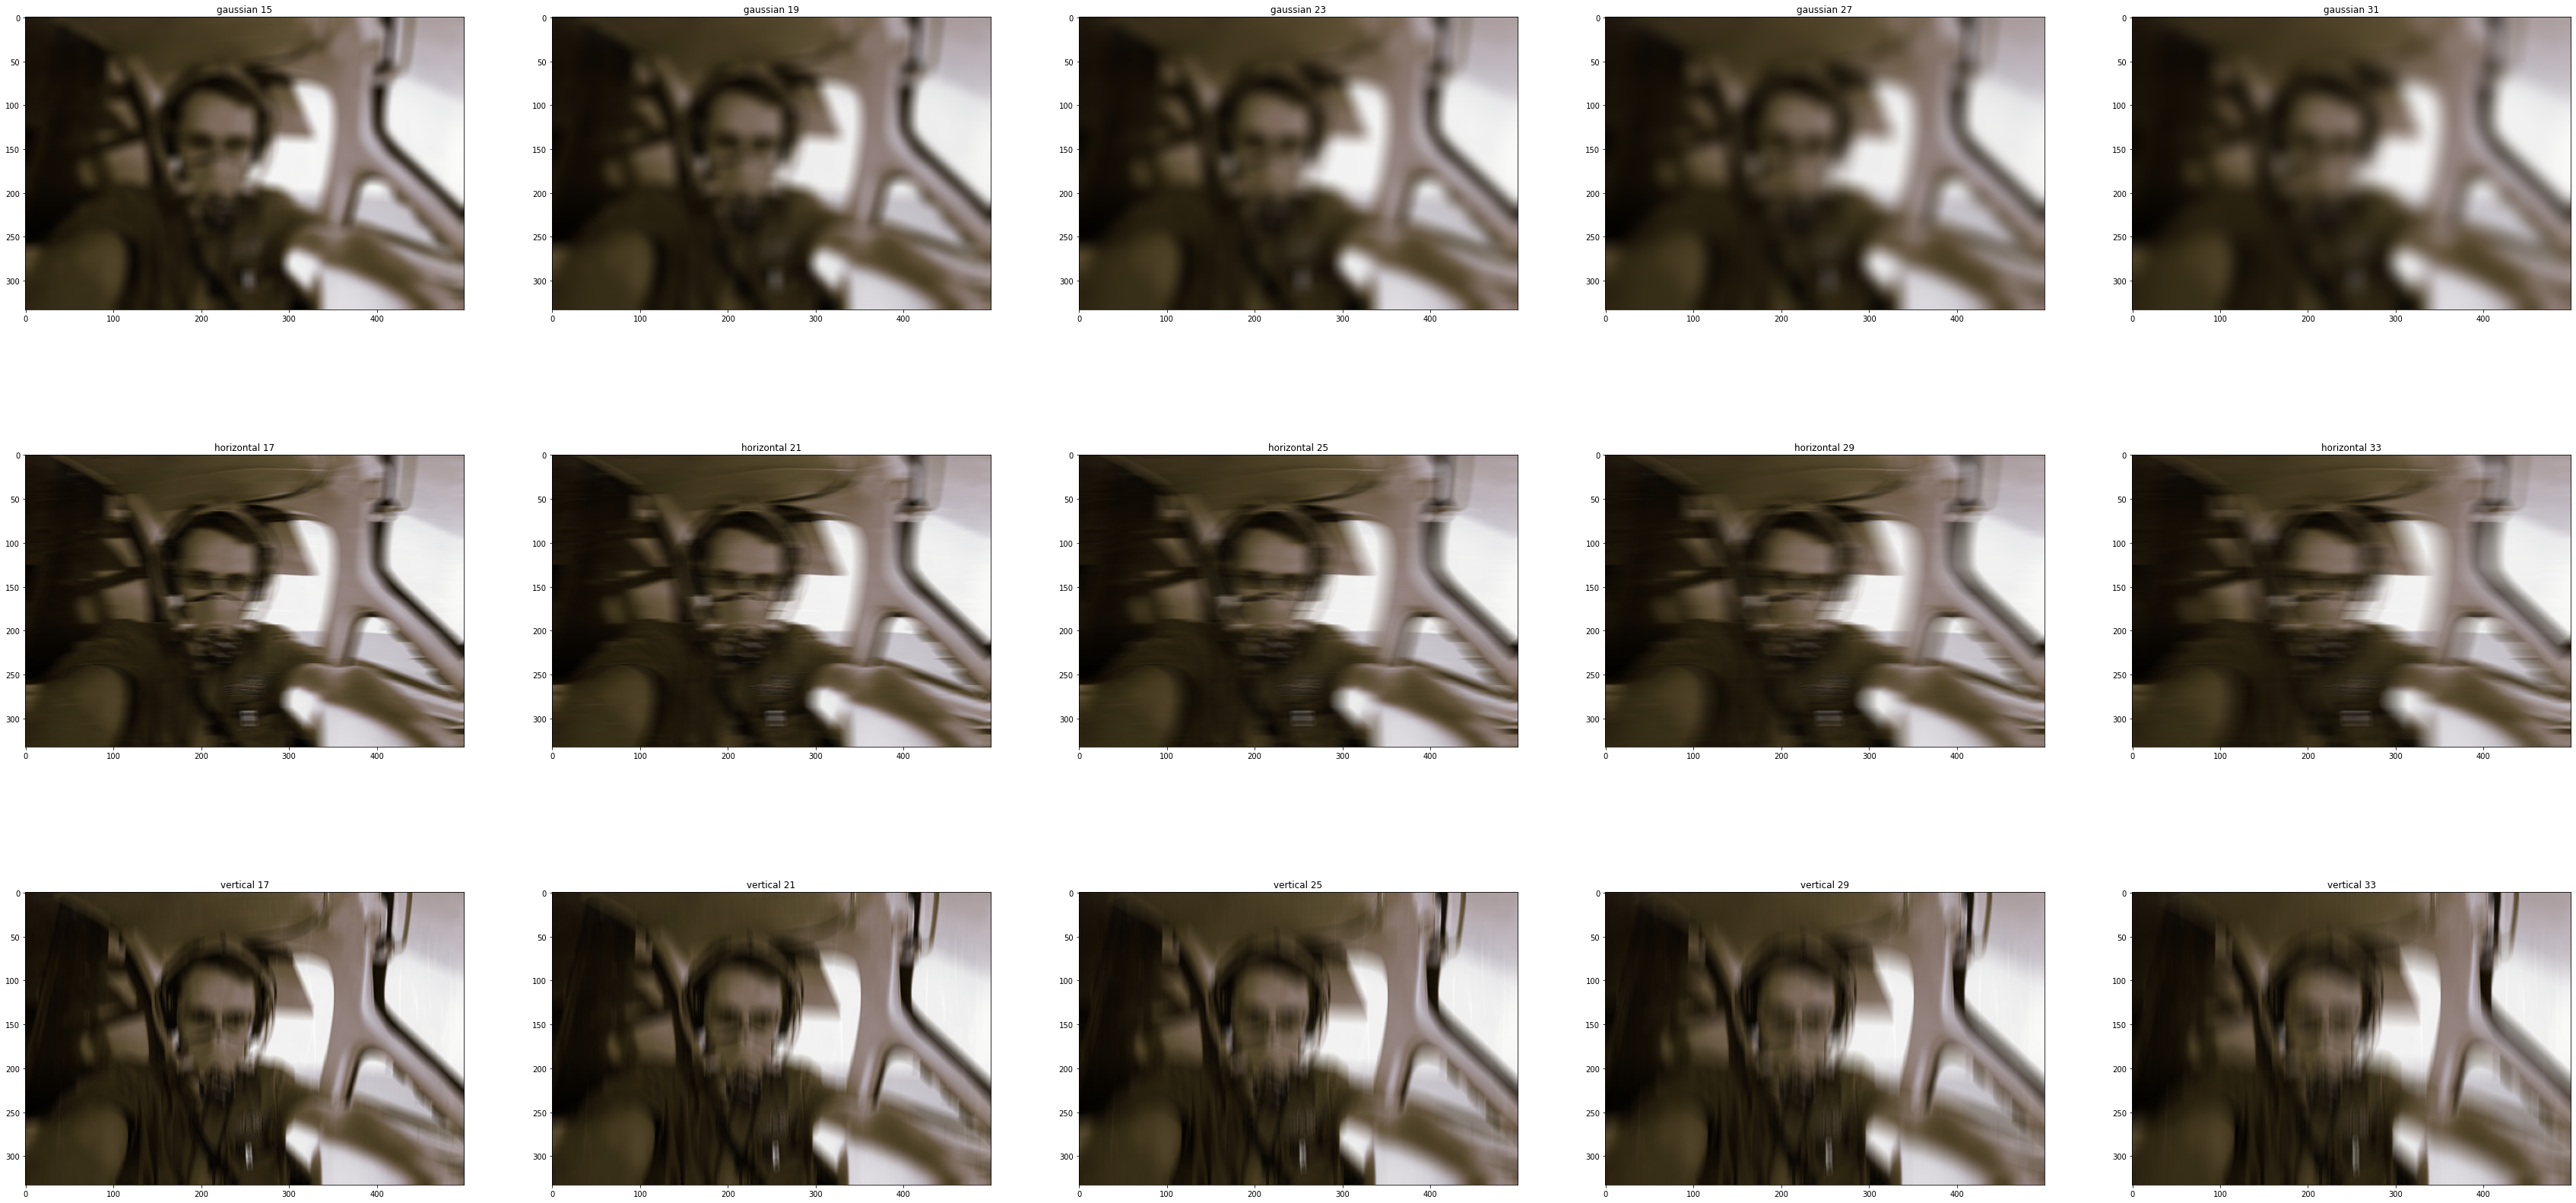

In [ ]:
gsizes = [15, 19, 23, 27, 31]
msizes = [17, 21, 25, 29, 33]
blurred_gaussian = [blur_gaussian(image2, k)[0] for k in gsizes]
horiz = [horiz_motion(image2, k)[0] for k in msizes]
vert = [vert_motion(image2, k)[0] for k in msizes]

titles_g = ['gaussian {}'.format(k) for k in gsizes]
titles_o = ['horizontal {}'.format(k) for k in msizes]
titles_v = ['vertical {}'.format(k) for k in msizes]

display_img(
    blurred_gaussian + horiz + vert
    ,
    3,5,
    (60,30),
    text = titles_g + titles_o + titles_v
)

In [ ]:
# dizionario di setup per le trasformazioni:
# - funzione della trasfromazione
# - output label
setup = {
    'gaussian' : [blur_gaussian, 'defocused_blurred'],
    'horizontal_motion' : [horiz_motion, 'motion_blurred'],
    'vertical_motion' : [vert_motion, 'motion_blurred'],
    'none' : ['', 'sharp']
    }
setup

{'gaussian': [<function __main__.blur_gaussian>, 'defocused_blurred'],
 'horizontal_motion': [<function __main__.horiz_motion>, 'motion_blurred'],
 'none': ['', 'sharp'],
 'vertical_motion': [<function __main__.vert_motion>, 'motion_blurred']}

In [ ]:
sampled = np.random.choice(all_data, 3500, replace = False)

In [ ]:
defocused_path = 'imagenet_mini_transformed/imagenet_mini_transformed/defocused_blurred/'
motion_path = 'imagenet_mini_transformed/imagenet_mini_transformed/motion_blurred/'
sharp_path = 'imagenet_mini_transformed/imagenet_mini_transformed/sharp/'

sizes = [15, 19, 23, 27, 31, 33]
shutil.rmtree('imagenet_mini_transformed')

os.makedirs(defocused_path)
os.makedirs(motion_path)
os.makedirs(sharp_path)

t1 = dt.now()
for i in range(len(sampled)):

  # percorso e tipo di trasformazione
  path = sampled[i]
  fname = path.split('/')[-1][:-5] + '.jpg'
  
  # lettura immagine
  img = cv2.imread(path)
  
  size = np.random.choice(sizes)
  
  img_defocused = img.copy()
  img_defocused = blur_gaussian(img_defocused, size)[0]

  defocus_type = np.random.choice(['horizontal_motion', 'vertical_motion'])

  #defocus = setup[defocus_type][0]
  defocus = np.random.choice([horiz_motion, vert_motion])
  img_motion = img.copy()
  img_motion = defocus(img_motion, size)[0]
  
  # scrittura immagine
  cv2.imwrite(sharp_path + fname, img)
  cv2.imwrite(motion_path + 'motion_' + fname, img_motion)
  cv2.imwrite(defocused_path + 'defocused_' + fname, img_defocused)
  
  
  if i % 1000 == 0:
    print(i)
t2 = dt.now()

In [ ]:
shutil.make_archive('imagenet_mini_transformed', 'zip', 'imagenet_mini_transformed')

'/content/imagenet_mini_transformed.zip'

In [ ]:
shutil.copyfile(
    'imagenet_mini_transformed.zip',
    '/content/drive/MyDrive/DSIM/image_classification/imagenet_mini_transformed.zip')

'/content/drive/MyDrive/DSIM/image_classification/imagenet_mini_transformed.zip'